In [354]:
import sys
sys.path.insert(0, '..')
import utils.game_utils as gu

import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

DEF_PASS_YDS = 250
DEF_RUSH_YDS = 100

def get_previous_record(year, week, team, all_games_df):
    records = all_games_df[(all_games_df['year'] == year)
                           & (all_games_df['week'] < week) &
                           (all_games_df['team'] == team)]
    if len(records) < 1:
        return None

    return records[-1:]


def get_all_previous_records(year, week, team, all_games_df):
    records = all_games_df[(all_games_df['year'] == year)
                           & (all_games_df['week'] < week) &
                           (all_games_df['team'] == team)]
    if len(records) < 1:
        return None

    return records
  
def data_from_previous_records(year, week, team, all_games_df, include_last_record=False):
  records = get_all_previous_records(year, week, team, all_games_df)
    
  count = 0
  rush_off_total = 0
  rush_off_mean = 0
  rush_off_std = 0
  rush_def_total = 0
  rush_def_mean = 0
  rush_def_std = 0
  pass_off_total = 0
  pass_off_mean = 0
  pass_off_std = 0
  pass_def_total = 0
  pass_def_mean = 0
  pass_def_std = 0
  # rush_off_total = DEF_RUSH_YDS
  # rush_off_mean = DEF_RUSH_YDS
  # rush_off_std = DEF_RUSH_YDS / 4
  # rush_def_total = DEF_RUSH_YDS
  # rush_def_mean = DEF_RUSH_YDS
  # rush_def_std = DEF_RUSH_YDS / 4
  # pass_off_total = DEF_PASS_YDS
  # pass_off_mean = DEF_PASS_YDS
  # pass_off_std = DEF_PASS_YDS / 4
  # pass_def_total = DEF_PASS_YDS
  # pass_def_mean = DEF_PASS_YDS
  # pass_def_std = DEF_PASS_YDS / 4
  last_record = None
  
  if records is not None:
    count = len(records)
    # team_rush_yards = records['team_rush_yards'].values
    # opponent_rush_yards = records['opponent_rush_yards'].values
    # team_pass_yards = records['team_pass_yards'].values
    # opponent_pass_yards = records['opponent_pass_yards'].values
    
    # rush_off_total = np.sum(np.append(team_rush_yards, DEF_RUSH_YDS))
    # rush_off_mean = np.mean(np.append(team_rush_yards, DEF_RUSH_YDS))
    # rush_off_std = np.std(np.append(team_rush_yards, DEF_RUSH_YDS))
    # rush_def_total = np.sum(np.append(opponent_rush_yards, DEF_RUSH_YDS))
    # rush_def_mean = np.mean(np.append(opponent_rush_yards, DEF_RUSH_YDS))
    # rush_def_std = np.std(np.append(opponent_rush_yards, DEF_RUSH_YDS))
    # pass_off_total = np.sum(np.append(team_pass_yards, DEF_PASS_YDS))
    # pass_off_mean = np.mean(np.append(team_pass_yards, DEF_PASS_YDS))
    # pass_off_std = np.std(np.append(team_pass_yards, DEF_PASS_YDS))
    # pass_def_total = np.sum(np.append(opponent_pass_yards, DEF_PASS_YDS))
    # pass_def_mean = np.mean(np.append(opponent_pass_yards, DEF_PASS_YDS))
    # pass_def_std = np.std(np.append(opponent_pass_yards, DEF_PASS_YDS))
    rush_off_total = np.sum(records['team_rush_yards'])
    rush_off_mean = np.mean(records['team_rush_yards'])
    rush_off_std = np.std(records['team_rush_yards'])
    rush_def_total = np.sum(records['opponent_rush_yards'])
    rush_def_mean = np.mean(records['opponent_rush_yards'])
    rush_def_std = np.std(records['opponent_rush_yards'])
    pass_off_total = np.sum(records['team_pass_yards'])
    pass_off_mean = np.mean(records['team_pass_yards'])
    pass_off_std = np.std(records['team_pass_yards'])
    pass_def_total = np.sum(records['opponent_pass_yards'])
    pass_def_mean = np.mean(records['opponent_pass_yards'])
    pass_def_std = np.std(records['opponent_pass_yards'])
    if include_last_record == True:
      last_record = records[-1:]    
  
  return {
    'count': count,
    'rush_off_total': rush_off_total,
    'rush_off_mean': rush_off_mean,
    'rush_off_std': rush_off_std,
    'rush_def_total': rush_def_total,
    'rush_def_mean': rush_def_mean,
    'rush_def_std': rush_def_std,
    'pass_off_total': pass_off_total,
    'pass_off_mean': pass_off_mean,
    'pass_off_std': pass_off_std,
    'pass_def_total': pass_def_total,
    'pass_def_mean': pass_def_mean,
    'pass_def_std': pass_def_std,
    'last_record': last_record,
  }
  

def trim_df(df, fields=None):
    if fields is None:
        fields = [
            'team_wins_before',
            'team_losses_before', 'team_ties_before', 'team_wins_after',
            'team_losses_after', 'team_ties_after', 'team_record_total_before',
            'team_record_total_after', 'team_record_normal_before',
            'team_record_normal_after', 'team_opprec_normal_before',
            'team_opprec_normal_after'
        ]
    out_fields = ['year', 'week', 'team_win', 'team']
    out_fields.extend(fields)
    return df[out_fields]


all_games_df = pd.read_csv('../../data/games/all_games_with_data.csv')
# data_from_previous_records(2018, 17, 'Tennessee Titans', all_games_df)

In [41]:
'''
Example of how we will calculate standard deviations
for PERFormance metrics. Using Std will indicate positive or negative
performance according to mean, as well as the scale of that
performance according to population.
'''

set = [75, 48, 125, 92, 68, 140]
m = np.mean(set)
s = np.std(set)
print(f'{m} mean')
print(f'{s} std')
print('---------')

# now calculate a new value relative to the std
test_vals = [23,45,68,81,85,99,125,210]
for val in test_vals:
  print(f'[{val}] --> {(val - m) / s} relative to std')


91.33333333333333 mean
32.12302739296047 std
---------
[23] --> -2.1272382735728104 relative to std
[45] --> -1.4423713172030275 relative to std
[68] --> -0.7263740446346181 relative to std
[81] --> -0.32167993405247364 relative to std
[85] --> -0.19715866925796766 relative to std
[99] --> 0.23866575752280325 relative to std
[125] --> 1.0480539786870922 relative to std
[210] --> 3.694130855570344 relative to std


In [373]:
def get_df_with_aggregates(index, all_games_df, side='team'):
    SIDE = side # can be opponent
    OTHER_SIDE = 'opponent' if SIDE == 'team' else 'team'
    WEEK_1_TRN = 0.5
    game_df = all_games_df.iloc[index]
    year = game_df['year']
    week = game_df['week']
    team = game_df[SIDE]
    opp_team = game_df[OTHER_SIDE]

    previous_df = get_previous_record(year, week, team, all_games_df)
    this_prev = data_from_previous_records(year, week, team, all_games_df, include_last_record=False)
    opp_prev = data_from_previous_records(year, week, opp_team, all_games_df, include_last_record=True)
    opp_previous_df = opp_prev['last_record']

    wins_before = 0
    losses_before = 0
    ties_before = 0

    wins_after = 0
    losses_after = 0
    ties_after = 0

    # todo: still need to handle these (before and after?)
    record_total_before = 0
    record_total_after = 0
    record_normal_before = 0
    record_normal_after = 0
    opp_strength_before = 0
    opp_strength_after = WEEK_1_TRN  # first week everyone is a 50/50 team
    # accumulated normalized records of all opponents
    opprec_normal_before = 0
    opprec_normal_after = 1.0
    opp_trn = WEEK_1_TRN

    '''
    ##  TEAM PERFORMANCE NUMBERS
        PERFOMANCE AGAINST STANDARD
        The numbers show how the team performed against the mean of the 
        opponent. These are not evaluative. They do not describe the
        "strength" of a team of performance -- only how this data
        compares to the "norm" or average at that time of the opponent.
        
        Recall that performance numbers are +/- STD numbers. This means
        they will mostly be found around +/- 0 but to describe outliers
        they can be +/- anywhere. These are not the same as the NORMAL
        values we calculate which all reside between 0 and 1
    '''
    week_rush_off_perf = 0
    week_rush_def_perf = 0
    week_pass_off_perf = 0
    week_pass_def_perf = 0
    week_comb_off_perf = 0
    week_comb_def_perf = 0
    all_rush_off_perf_before = 0
    all_rush_off_perf_after = 0
    all_rush_def_perf_before = 0
    all_rush_def_perf_after = 0
    all_pass_off_perf_before = 0
    all_pass_off_perf_after = 0
    all_pass_def_perf_before = 0
    all_pass_def_perf_after = 0
    all_comb_off_perf_before = 0
    all_comb_off_perf_after = 0
    all_comb_def_perf_before = 0
    all_comb_def_perf_after = 0
    
    ## INFO FROM THIS GAME
    win = bool(game_df[f'{SIDE}_win'])
    tie = game_df['team_score'] == game_df['opponent_score'] # no need for SIDE, just see if both scores are the same
    loss = win == False and tie == False

    def get_val_or(df, field):
        val = df.iloc[0][field]
        if np.isnan(val):
            return 0
        return val
    def get_normalized(x, min, max):
        return (x-min) / (max-min)
    def get_rel_to_std(val, mean, std):
        MAX = 3.0
        MIN = -3.0
        if std == 0:
          return 0.0
        real_res = (val - mean) / std
        ''' 
        to prevent very large differences found in the early week -- 
        when there are very few data points -- we want to clamp values
        to within a "reasonable" range
        '''
        return max(min(real_res, MAX), MIN)
    def get_opprec_normal_after(opp_previous_df, record_normal_after):
        if opp_previous_df is None:
            return 1.0

        pre_opprec_after = get_val_or(opp_previous_df, f'{SIDE}_opprec_normal_after')
        pre_trn_after = get_val_or(opp_previous_df, f'{SIDE}_record_normal_after')

        new_opprec = (pre_opprec_after + pre_trn_after) / 2
        final_new_opprec = (new_opprec + record_normal_after) / 2

        return final_new_opprec
    def get_opp_strength_after(opp_previous_df, opp_strength_before):
        '''
        Opponent Strength is essentially the TRN value
        (record_normal) or the wins/losses of a team.
        We want to accumulate the opp_strength from week to
        week to see how strong all opponents have been.
        '''
        if opp_previous_df is None:
            return 1.0

        opp_prev_trn = get_val_or(opp_previous_df, f'{SIDE}_record_normal_after')
        # normalized (/2)
        return (opp_strength_before + opp_prev_trn) / 2


    ## DATA FROM PREVIOUS GAME
    if previous_df is not None:
        try:
            wins_before = get_val_or(previous_df, f'{SIDE}_wins_after')
            losses_before = get_val_or(previous_df, f'{SIDE}_losses_after')
            ties_before = get_val_or(previous_df, f'{SIDE}_ties_after')
            record_total_before = get_val_or(previous_df, f'{SIDE}_record_total_after')
            record_normal_before = get_val_or(previous_df, f'{SIDE}_record_normal_after')
            opprec_normal_before = get_val_or(previous_df, f'{SIDE}_opprec_normal_after')
            opp_strength_before = get_val_or(previous_df, f'{SIDE}_opp_strength_after')

            wins_after = wins_before
            losses_after = losses_before
            ties_after = ties_before
            record_total_after = record_total_before
            record_normal_after = record_normal_before
            opprec_normal_after = get_opprec_normal_after(opp_previous_df, record_normal_after)
            opp_strength_after = get_opp_strength_after(opp_previous_df, opp_strength_before)
            opp_trn = get_val_or(opp_previous_df, f'{SIDE}_record_normal_after')
            
        except Exception as e:
            print(e)


    if opp_prev is not None:
        week_rush_off_perf = get_rel_to_std(game_df[f'{SIDE}_rush_yards'], 
                                            opp_prev['rush_def_mean'], 
                                            opp_prev['rush_def_std'])
        week_rush_def_perf = -1 * get_rel_to_std(game_df[f'{OTHER_SIDE}_rush_yards'], 
                                            this_prev['rush_def_mean'], 
                                            this_prev['rush_def_std'])

        week_pass_off_perf = get_rel_to_std(game_df[f'{SIDE}_pass_yards'], 
                                            opp_prev['pass_def_mean'], 
                                            opp_prev['pass_def_std'])
        week_pass_def_perf = -1 * get_rel_to_std(game_df[f'{OTHER_SIDE}_pass_yards'], 
                                            this_prev['pass_def_mean'], 
                                            this_prev['pass_def_std'])            

        week_comb_off_perf = (week_rush_off_perf + week_pass_off_perf) / 2
        week_comb_def_perf = (week_rush_def_perf + week_pass_def_perf) / 2    

    ## CALCULATE NEW DATA (after)
    if win:
        wins_after += 1
    if tie:
        ties_after += 1
    if loss:
        losses_after += 1

    ## CALCULATE RECORD NORMAL
    record_total_after = wins_after - losses_after # eg: +2 or -7 etc.
    # todo: CANNOT USE WEEK as there may have been a bye. Must use "# of prev entries"
    record_normal_after = get_normalized(record_total_after, week * -1, week)


    # todo: maybe we should be authoring is_tie as well?

    all_games_df.at[index, [
        f'{SIDE}_wins_before',
        f'{SIDE}_wins_after',
        f'{SIDE}_losses_before',
        f'{SIDE}_losses_after',
        f'{SIDE}_ties_before',
        f'{SIDE}_ties_after',
        f'{SIDE}_record_total_before',
        f'{SIDE}_record_total_after',
        f'{SIDE}_record_normal_before',
        f'{SIDE}_record_normal_after',
        f'{SIDE}_opp_strength_before',
        f'{SIDE}_opp_strength_after',
        f'{SIDE}_opprec_normal_before',
        f'{SIDE}_opprec_normal_after',
        f'{SIDE}_opp_trn',
        f'{SIDE}_week_rush_off_perf',
        f'{SIDE}_week_rush_def_perf',
        f'{SIDE}_week_pass_off_perf',
        f'{SIDE}_week_pass_def_perf',
        f'{SIDE}_week_comb_off_perf',
        f'{SIDE}_week_comb_def_perf',
    ]] = [
        int(wins_before), 
        int(wins_after), 
        int(losses_before), 
        int(losses_after), 
        int(ties_before),
        int(ties_after), 
        int(record_total_before), 
        int(record_total_after),
        float(record_normal_before), 
        float(record_normal_after), 
        float(opp_strength_before),
        float(opp_strength_after), 
        float(opprec_normal_before), 
        float(opprec_normal_after), 
        float(opp_trn),
        float(week_rush_off_perf),
        float(week_rush_def_perf),
        float(week_pass_off_perf),
        float(week_pass_def_perf),
        float(week_comb_off_perf),
        float(week_comb_def_perf),
    ]

    return all_games_df.iloc[index]


def get_team_df(team, year, all_df):
    return all_df[(all_df['team'] == team) & (all_df['year'] == year)]
def get_year_df(year, all_df):
    return all_df[all_df['year'] == year]
def get_year_up_to_week_df(year, week, all_df):
    return all_df[(all_df['year'] == year) & (all_df['week'] <= week)]

## - - - - - - - - - - - - - - - - - - - -- - - -- - - - - - - -
## C O N F I G
## - - - - - - - - - - - - - - - - - - - -- - - -- - - - - - - -
YEAR = 2018
UP_TO_WEEK = 16
## ADD NEW COLUMNS TO ALL GAMES AND CREATE NEW ALL_GAMES_PLUS_DF (agp_df)
# todo: ALL NEED `opponent_` versions also!
new_col_df = pd.DataFrame(columns=[
    'team_wins_before',               'team_wins_after',
    'team_losses_before',             'team_losses_after', 
    'team_ties_before',               'team_ties_after', 
    'team_record_total_before',       'team_record_total_after',  
    'team_record_normal_before',      'team_record_normal_after',  
    'team_opp_strength_before',       'team_opp_strength_after', 
    'team_opprec_normal_before',      'team_opprec_normal_after',
    
    'team_week_rush_off_perf',        'team_week_rush_def_perf',  # week is always after
    'team_week_pass_off_perf',        'team_week_pass_def_perf',  # week is always after
    'team_week_comb_off_perf',        'team_week_comb_def_perf',  # week is always after
    
    'team_all_rush_off_perf_before',  'team_all_rush_off_perf_after',  
    'team_all_rush_def_perf_before',  'team_all_rush_def_perf_after',
    'team_all_pass_off_perf_before',  'team_all_pass_off_perf_after',  
    'team_all_pass_def_perf_before',  'team_all_pass_def_perf_after',
    'team_all_comb_off_perf_before',  'team_all_comb_off_perf_after',  
    'team_all_comb_def_perf_before',  'team_all_comb_def_perf_after',
])
agp_df = all_games_df.join(new_col_df, how="outer")
year_df = get_year_df(YEAR, agp_df)

for index in year_df.index:
    get_df_with_aggregates(index, agp_df)
show_fields = [
    'opponent',
    # 'team_wins_after',            'team_losses_after',        'team_ties_after',
    'opponent_rush_yards',        'team_rush_yards',
    'opponent_pass_yards',        'team_pass_yards',
    'team_week_rush_off_perf',    'team_week_rush_def_perf',
    'team_week_pass_off_perf',    'team_week_pass_def_perf',
    'team_week_comb_off_perf',    'team_week_comb_def_perf',
    # 'team_record_total_after',        'team_record_normal_before',
    # 'team_record_normal_after',    # 'team_opp_strength_before',
    # 'team_opp_strength_after',     # 'team_opprec_normal_before',
    # 'team_opprec_normal_after'        'team_opp_trn',
]
num_fields = [
  'team_wins_after',            'team_losses_after',        'team_ties_after',
  'opponent_rush_yards',        'team_rush_yards',
  'team_week_rush_off_perf',    'team_week_rush_def_perf',
  'team_week_pass_off_perf',    'team_week_pass_def_perf',
  'team_week_comb_off_perf',    'team_week_comb_def_perf',
  'team_record_total_after',    'team_record_normal_before',
  'team_record_normal_after',   'team_opp_trn',  
]
agp_df[num_fields] = agp_df[num_fields].apply(pd.to_numeric)

year_df = get_year_df(YEAR, agp_df)
# trim_df(year_df[year_df['team'] == gu.TEAM_NAME['Saints']], show_fields)

In [374]:
trim_df(year_df[year_df['team'] == gu.TEAM_NAME['Chiefs']], show_fields)
# trim_df(year_df[(year_df['team'] == gu.TEAM_NAME['Saints']) & (year_df['week'] <= 2)], show_fields)

,year,week,team_win,team,opponent,opponent_rush_yards,team_rush_yards,opponent_pass_yards,team_pass_yards,team_week_rush_off_perf,team_week_rush_def_perf,team_week_pass_off_perf,team_week_pass_def_perf,team_week_comb_off_perf,team_week_comb_def_perf
4115,2018,1,1,Kansas City Chiefs,Los Angeles Chargers,123,106,424,256,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000
4139,2018,2,1,Kansas City Chiefs,Pittsburgh Steelers,33,127,452,326,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000
4176,2018,3,1,Kansas City Chiefs,San Francisco 49ers,178,77,251,314,-3.000000,-2.222222,0.359223,3.000000,-1.320388,0.388889
4221,2018,4,1,Kansas City Chiefs,Denver Broncos,159,142,245,304,3.000000,-0.797527,1.904439,1.469970,2.452220,0.336221
4232,2018,5,1,Kansas City Chiefs,Jacksonville Jaguars,101,126,430,313,0.726851,0.399288,2.574137,-0.910633,1.650494,-0.255673
4279,2018,6,0,Kansas City Chiefs,New England Patriots,173,94,340,352,-0.466303,-1.070519,0.918789,0.221100,0.226243,-0.424710
4306,2018,7,1,Kansas City Chiefs,Cincinnati Bengals,65,198,187,358,1.479725,1.245718,0.546684,2.010181,1.013205,1.627949
4322,2018,8,1,Kansas City Chiefs,Denver Broncos,189,49,262,303,-1.013239,-1.358959,1.091746,0.719143,0.039253,-0.319908
4353,2018,9,1,Kansas City Chiefs,Cleveland Browns,102,139,308,375,0.002452,0.478389,1.046955,0.167269,0.524703,0.322829
4376,2018,10,1,Kansas City Chiefs,Arizona Cardinals,94,118,208,249,-0.720995,0.601836,0.056650,1.273302,-0.332173,0.937569


In [375]:
trim_df(year_df[year_df['team'] == gu.TEAM_NAME['49ers']], show_fields)
# trim_df(year_df[(year_df['team'] == gu.TEAM_NAME['Falcons']) & (year_df['week'] <= 3)], show_fields)

,year,week,team_win,team,opponent,opponent_rush_yards,team_rush_yards,opponent_pass_yards,team_pass_yards,team_week_rush_off_perf,team_week_rush_def_perf,team_week_pass_off_perf,team_week_pass_def_perf,team_week_comb_off_perf,team_week_comb_def_perf
4109,2018,1,0,San Francisco 49ers,Minnesota Vikings,116,90,244,261,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000
4148,2018,2,1,San Francisco 49ers,Detroit Lions,98,190,347,206,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000
4177,2018,3,0,San Francisco 49ers,Kansas City Chiefs,77,178,314,251,2.222222,3.000000,-3.000000,-0.359223,-0.388889,1.320388
4215,2018,4,0,San Francisco 49ers,Los Angeles Chargers,126,76,250,298,-1.200295,-1.819622,0.265325,1.203106,-0.467485,-0.308258
4242,2018,5,0,San Francisco 49ers,Arizona Cardinals,56,147,170,349,0.154467,2.585775,1.479297,2.736083,0.816882,2.660929
4281,2018,6,0,San Francisco 49ers,Green Bay Packers,116,174,425,245,1.666064,-0.838706,0.149916,-2.608203,0.907990,-1.723455
4304,2018,7,0,San Francisco 49ers,Los Angeles Rams,146,107,202,170,0.156732,-1.942874,-0.860770,1.096144,-0.352019,-0.423365
4333,2018,8,0,San Francisco 49ers,Arizona Cardinals,88,107,252,190,-1.204543,0.601148,-0.940281,0.327621,-1.072412,0.464384
4338,2018,9,1,San Francisco 49ers,Oakland Raiders,102,143,179,262,-0.028279,0.032355,-0.163490,1.250088,-0.095884,0.641222
4390,2018,10,0,San Francisco 49ers,New York Giants,97,124,188,250,0.039427,0.226593,-0.030135,0.973775,0.004646,0.600184


In [376]:
# tdf = year_df[year_df['team'] == gu.TEAM_NAME['49ers']]
data_from_previous_records(year=2018,week=12,all_games_df=year_df, team=gu.TEAM_NAME['49ers'])

{'count': 10,
 'rush_off_total': 1336,
 'rush_off_mean': 133.6,
 'rush_off_std': 37.11926723414674,
 'rush_def_total': 1022,
 'rush_def_mean': 102.2,
 'rush_def_std': 24.252010225958593,
 'pass_off_total': 2482,
 'pass_off_mean': 248.2,
 'pass_off_std': 49.29462445338234,
 'pass_def_total': 2571,
 'pass_def_mean': 257.1,
 'pass_def_std': 78.26550964505374,
 'last_record': None}

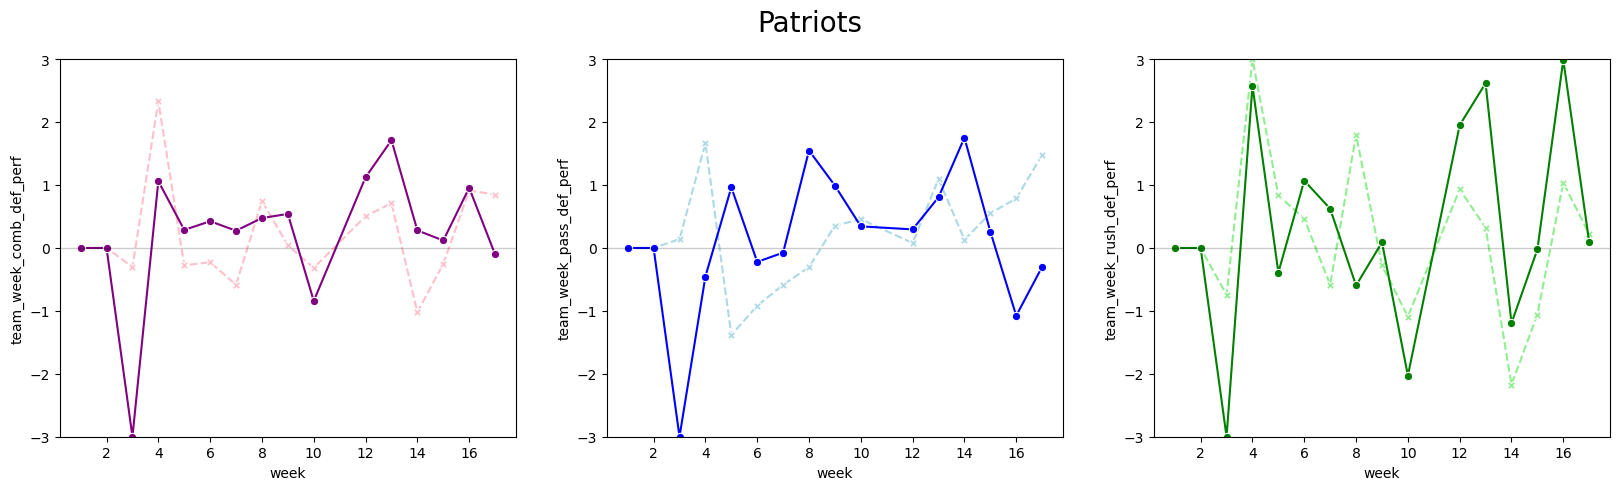

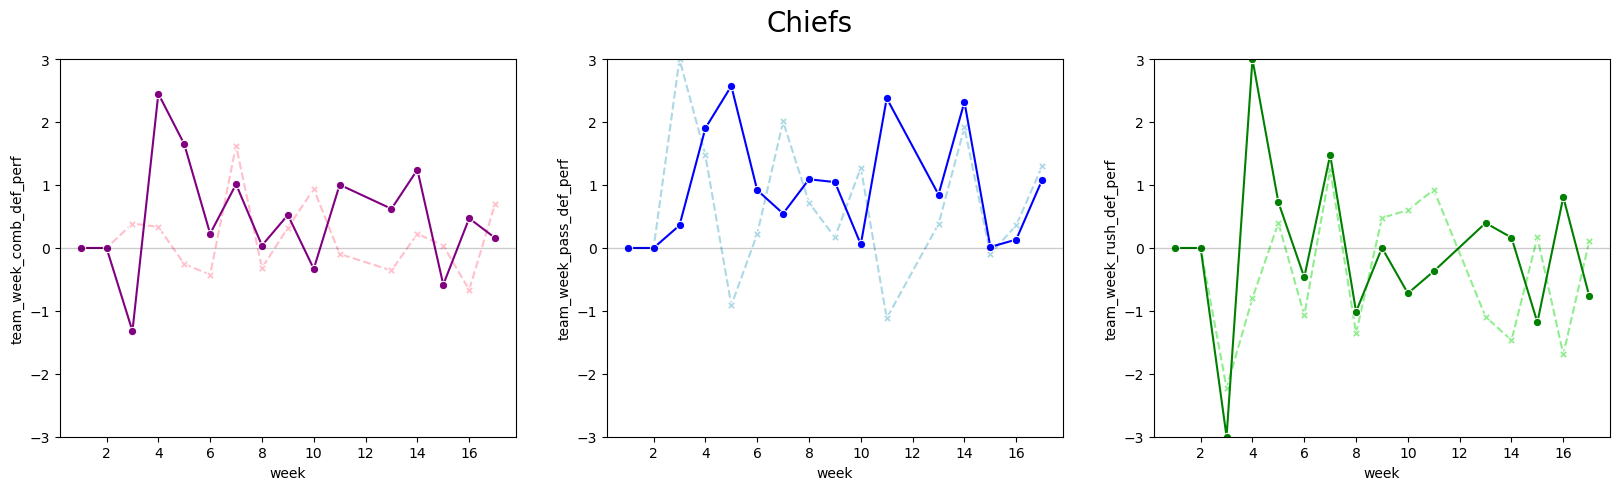

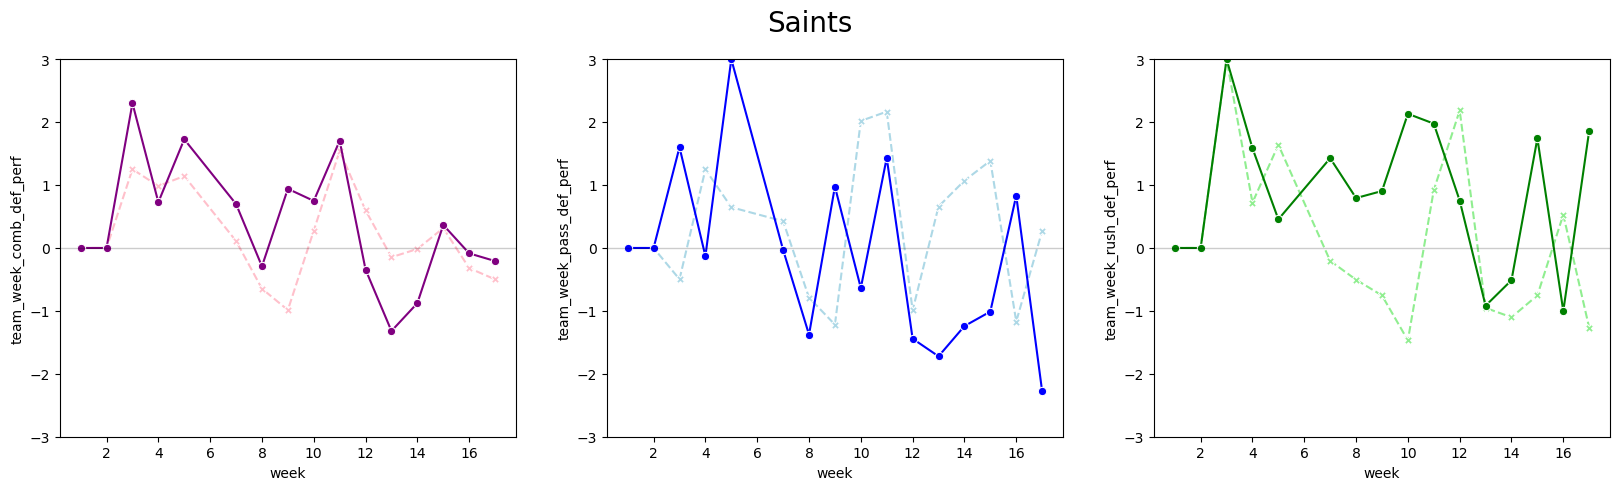

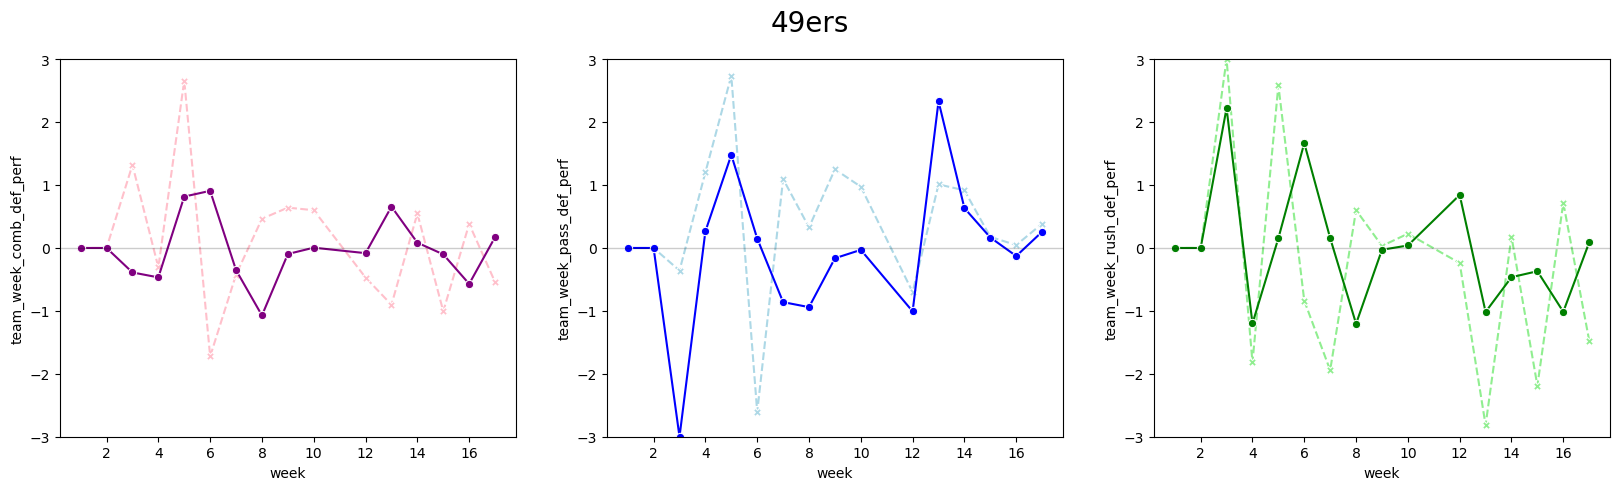

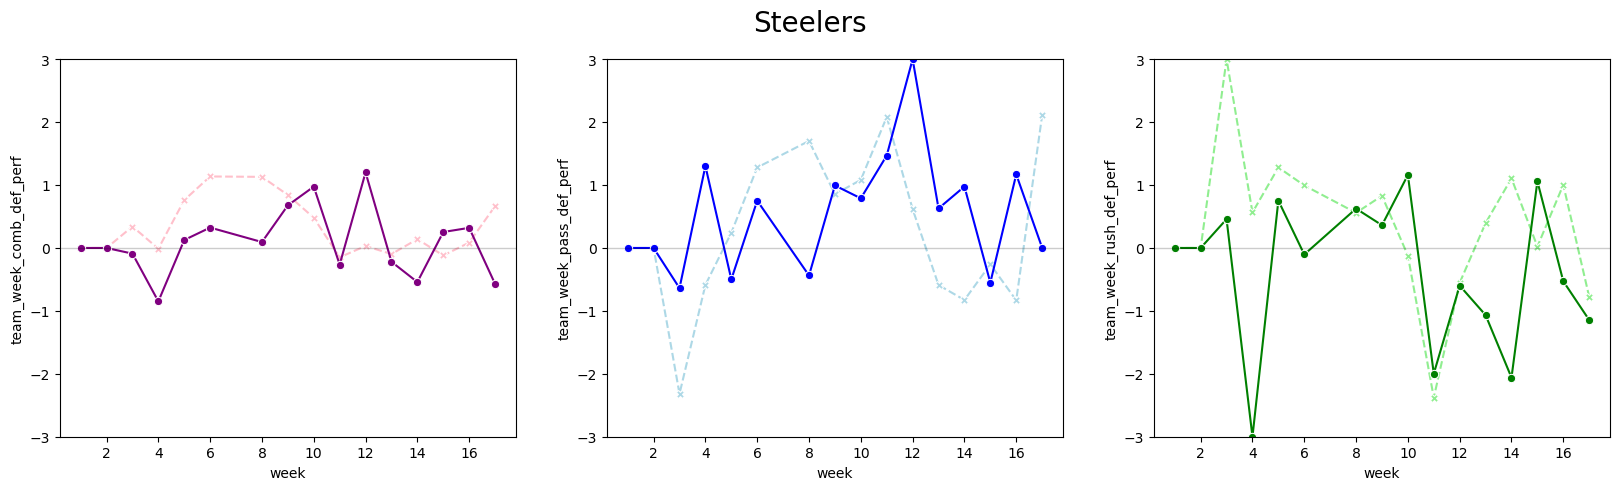

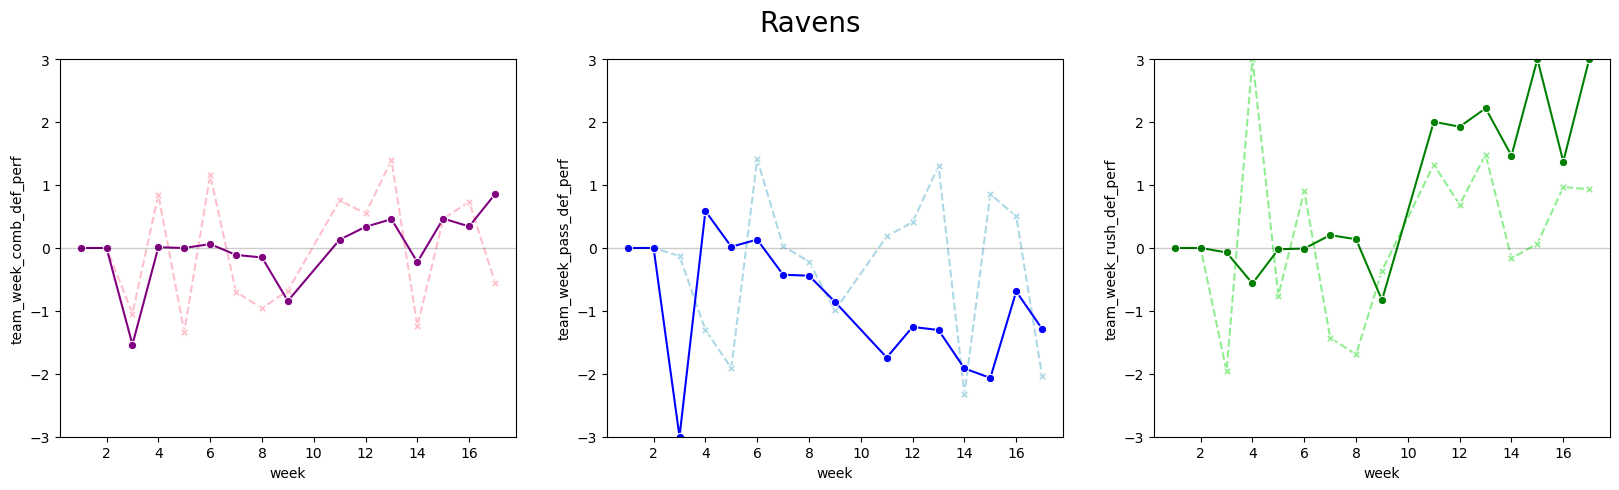

In [431]:
def plot_compare(nickname, year_df, type='comb'):
  tdf = year_df[year_df['team'] == gu.TEAM_NAME[nickname]]
  types = ['comb','pass','rush']
  # fig = plt.figure(figsize=(10,5),dpi=100)
  
  fig, axs = plt.subplots(ncols=3, figsize=(20,5),dpi=100)
  sns.lineplot(ax=axs[0], data=tdf, x='week', y=f'team_week_comb_def_perf', linestyle='--', marker='X', color='pink')
  sns.lineplot(ax=axs[0], data=tdf, x='week', y=f'team_week_comb_off_perf', marker='o', color='purple')

  sns.lineplot(ax=axs[1], data=tdf, x='week', y=f'team_week_pass_def_perf', linestyle='--', marker='X', color='lightblue')
  sns.lineplot(ax=axs[1], data=tdf, x='week', y=f'team_week_pass_off_perf', marker='o', color='blue')

  sns.lineplot(ax=axs[2], data=tdf, x='week', y=f'team_week_rush_def_perf', linestyle='--', marker='X', color='lightgreen')
  sns.lineplot(ax=axs[2], data=tdf, x='week', y=f'team_week_rush_off_perf', marker='o', color='green')
  
  axs[0].axhline(y=0, lw=1, color='black', alpha=0.2)
  axs[1].axhline(y=0, lw=1, color='black', alpha=0.2)
  axs[2].axhline(y=0, lw=1, color='black', alpha=0.2)
  axs[0].set_ylim(-3,3)
  axs[1].set_ylim(-3,3)
  axs[2].set_ylim(-3,3)
  
  fig.suptitle(f'{nickname}', fontsize=20)

 
teams = [
         'Patriots',
         'Chiefs',
         'Saints',
         '49ers',
         'Steelers',
         'Ravens',
        ]

for team in teams:
  plot_compare(team, year_df)

78.13333333333334 rush_def_mean
25.927762897883976 rush_def_std
2.7718036048737495


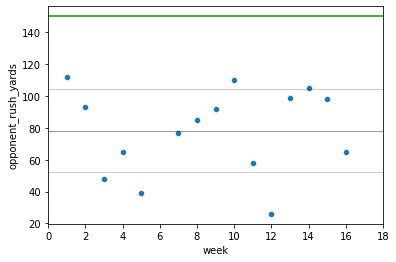

In [158]:
year = 2018
week = 17
team = gu.TEAM_NAME['Saints']
test_val = 150
records = get_all_previous_records(year, week, team, all_games_df)
data = data_from_previous_records(year, week, team, agp_df)
comparison = (test_val - data['rush_def_mean']) / data['rush_def_std']
m = data["rush_def_mean"]
s = data["rush_def_std"]

sns.scatterplot(data=records, x='week', y='opponent_rush_yards')
plt.xlim(0,week+1)
# test line
plt.axhline(y=test_val, lw=2, color='green', alpha=0.7)
# std lines
plt.axhline(y=m + s, lw=1, color='black', alpha=0.2)
plt.axhline(y=m, lw=1, color='black', alpha=0.4)
plt.axhline(y=m - s, lw=1, color='black', alpha=0.2)

print(f'{m} rush_def_mean')
print(f'{s} rush_def_std')
print(f'{comparison}')

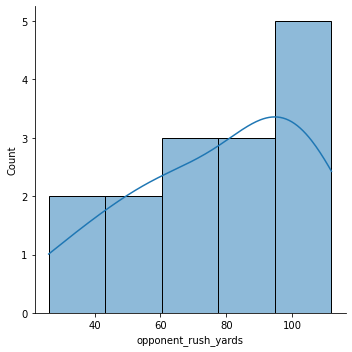

In [152]:
# sns.histplot(data=records, x='opponent_rush_yards', bins=8)
# sns.displot(records, x='opponent_rush_yards', binwidth=20)
# sns.displot(records, x='opponent_rush_yards', bins=[50, 70, 90, 110, 130])
# sns.displot(records, x='opponent_rush_yards', kind='kde')
# sns.displot(records, x='opponent_rush_yards', kind='kde', bw_adjust=.25, fill=True)
sns.displot(records, x='opponent_rush_yards', kde=True)


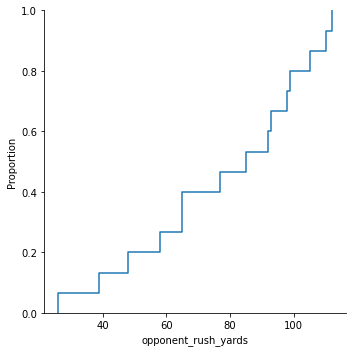

In [153]:
sns.displot(records, x='opponent_rush_yards', kind='ecdf')


,year,week,team_win,team,opponent,team_wins_after,team_losses_after,team_ties_after,team_week_rush_off_perf,team_week_rush_def_perf,team_record_normal_after,team_opp_strength_after
4106,2018,1,0,New Orleans Saints,Tampa Bay Buccaneers,0,1,0,NaN,NaN,0.0,0.5
4144,2018,2,1,New Orleans Saints,Cleveland Browns,1,1,0,NaN,NaN,0.5,0.5
4165,2018,3,1,New Orleans Saints,Atlanta Falcons,2,1,0,NaN,NaN,0.666667,0.5
4217,2018,4,1,New Orleans Saints,New York Giants,3,1,0,NaN,NaN,0.75,0.416667
4250,2018,5,1,New Orleans Saints,Washington Redskins,4,1,0,NaN,NaN,0.8,0.541667
4301,2018,7,1,New Orleans Saints,Baltimore Ravens,5,1,0,NaN,NaN,0.785714,0.604167
4335,2018,8,1,New Orleans Saints,Minnesota Vikings,6,1,0,NaN,NaN,0.8125,0.659226
4358,2018,9,1,New Orleans Saints,Los Angeles Rams,7,1,0,NaN,NaN,0.833333,0.829613
4367,2018,10,1,New Orleans Saints,Cincinnati Bengals,8,1,0,NaN,NaN,0.85,0.727307
4412,2018,11,1,New Orleans Saints,Philadelphia Eagles,9,1,0,NaN,NaN,0.863636,0.588653


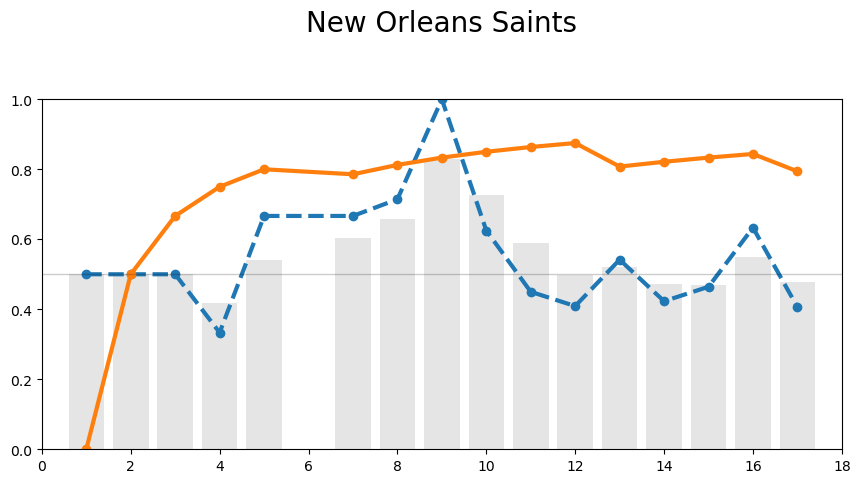

In [173]:
def multi_plot(team_name):
    final_name = team_name
    if ' ' not in team_name:
        final_name = gu.TEAM_NAME[team_name]

    team_df = year_df[year_df['team'] == final_name]
    fig = plt.figure(figsize=(10, 5), dpi=100)
    weeks = team_df['week']
    opp_str = team_df['team_opp_strength_after']
    opp_trn = team_df['team_opp_trn']
    trn = team_df['team_record_normal_after']

    fig.suptitle(final_name, fontsize=20)

    plt.plot(weeks, opp_trn, '--o', lw=3)
    plt.bar(weeks, opp_str, alpha=0.1, color='black')
    plt.plot(weeks, trn, '-o', lw=3)
    plt.ylim(0,1)
    plt.xlim(0,18)
    plt.axhline(y=0.5, lw=1, color='black', alpha=0.2)
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.8)


team_name = 'Saints'
multi_plot(team_name)
trim_df(year_df[year_df['team'] == gu.TEAM_NAME[team_name]], show_fields)

In [55]:
# names = ['Saints','49ers','Patriots','Chiefs','Steelers']

# for name in names:
#   multi_plot(name)

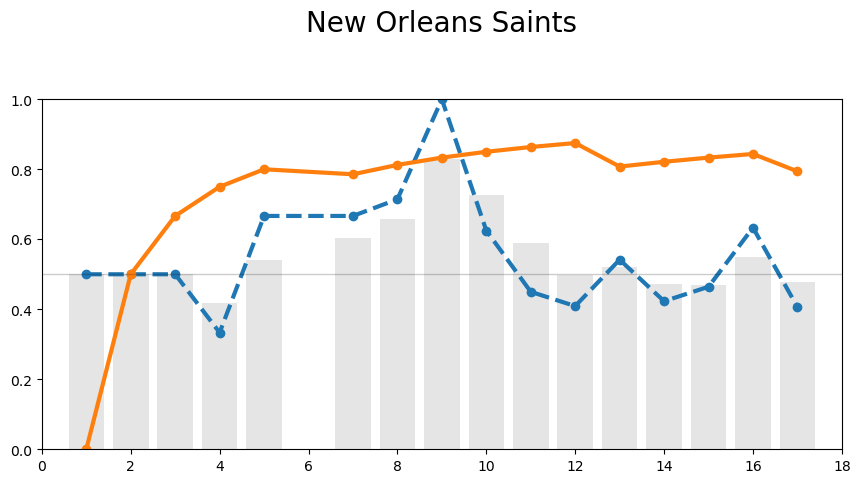

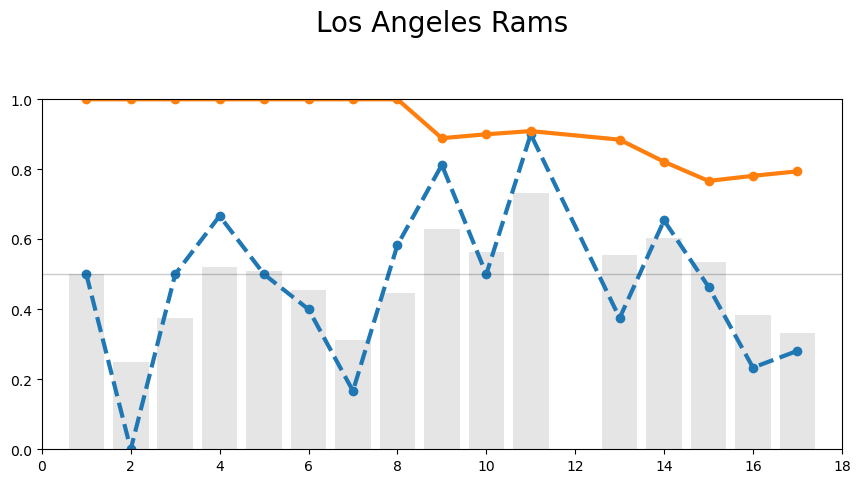

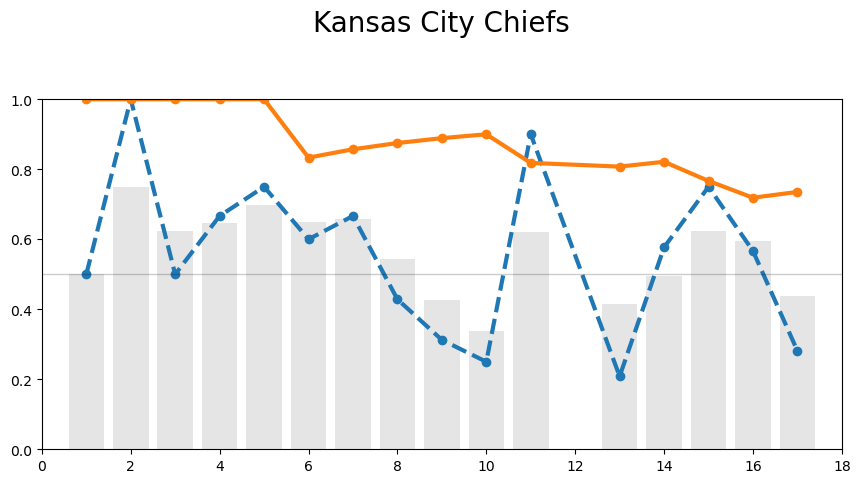

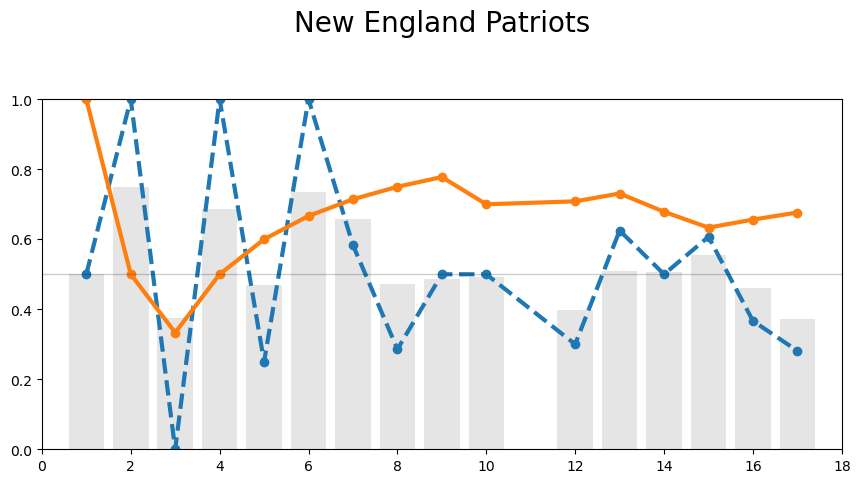

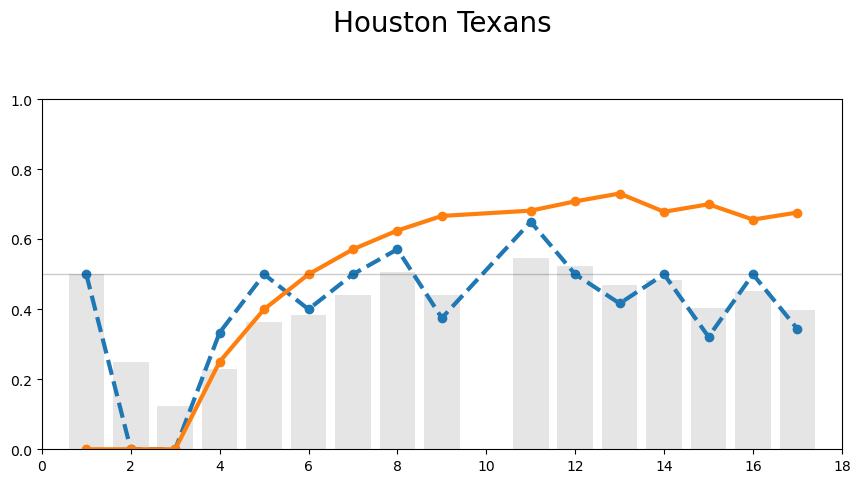

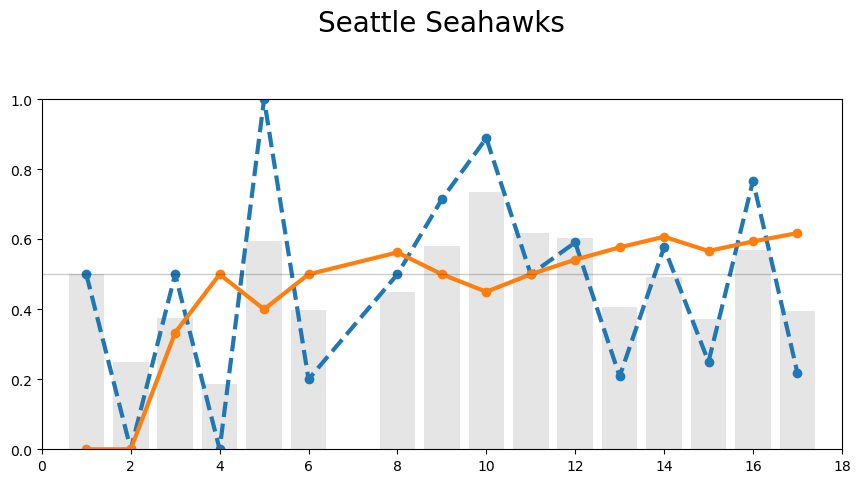

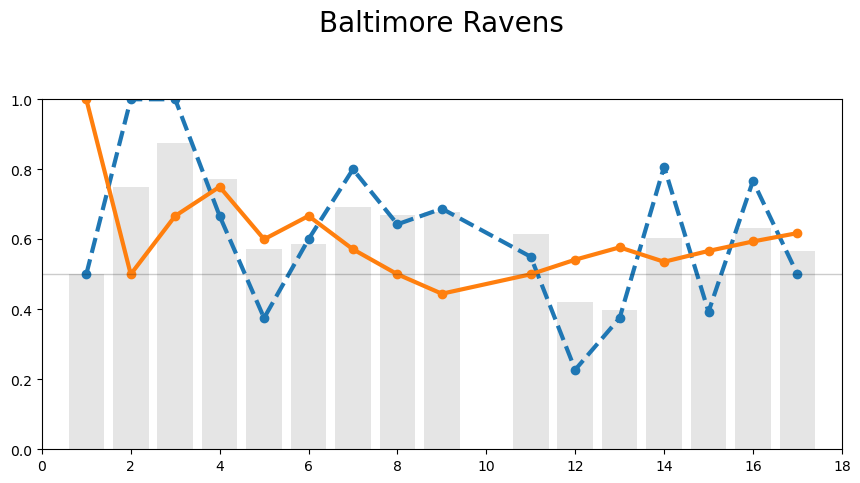

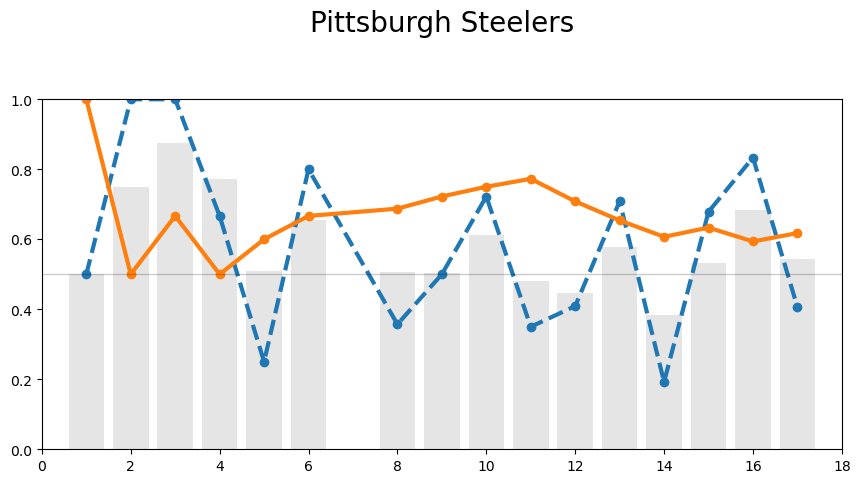

In [97]:
final_df = year_df[(year_df['week'] == 17) & (year_df['home'] == 1)]
best_df = final_df.sort_values('team_wins_after', ascending=False)[:8]
for name in best_df['team'].values:
    multi_plot(name)


In [100]:
tdf = year_df[year_df['team'] == gu.TEAM_NAME['Saints']]

In [101]:
tdf[show_fields].describe()

,team_opp_trn
count,16.000000
mean,0.552103
std,0.162829
min,0.333333
25%,0.443269
50%,0.500000
75%,0.641667
max,1.000000


In [102]:
tdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16 entries, 4106 to 4586
Data columns (total 83 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   date                              16 non-null     object 
 1   year                              16 non-null     int64  
 2   week                              16 non-null     int64  
 3   team                              16 non-null     object 
 4   team_score                        16 non-null     int64  
 5   opponent                          16 non-null     object 
 6   opponent_score                    16 non-null     int64  
 7   win                               16 non-null     int64  
 8   home                              16 non-null     int64  
 9   overtime                          16 non-null     int64  
 10  year_week                         16 non-null     object 
 11  team_win                          16 non-null     int64  
 12  oppon

In [108]:
tdf['team_opp_strength_after']

4106         0.5
4144         0.5
4165         0.5
4217    0.416667
4250    0.541667
4301    0.604167
4335    0.659226
4358    0.829613
4367    0.727307
4412    0.588653
4422    0.498872
4449    0.520269
4487    0.471673
4543    0.467979
4570    0.550656
4586    0.478453
Name: team_opp_strength_after, dtype: object

In [109]:
pd.to_numeric(tdf['team_opp_strength_after'])

4106    0.500000
4144    0.500000
4165    0.500000
4217    0.416667
4250    0.541667
4301    0.604167
4335    0.659226
4358    0.829613
4367    0.727307
4412    0.588653
4422    0.498872
4449    0.520269
4487    0.471673
4543    0.467979
4570    0.550656
4586    0.478453
Name: team_opp_strength_after, dtype: float64